In [60]:
# List of questions and to be done items that are not obvious
# 1. 20836 source that have scienceFlux smaller than 0?
# 2. how do I see nondiaSource for diaObjects 

# Explore AuxTel Prompt Processing Subtractions + APDB
Neven Caplar 
Started: 2023-09-12

Goals: Evaluate the quality of prompt processing on auxtel images

    1. Find the known variables and see how these look in images and in lightcurves

References
1. Track Prompt Processing AuxTel runs here  
    https://confluence.lsstcorp.org/display/DM/Prompt+Processing+with+AuxTel+Imaging+Survey+Data+2023  

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib

# astropy imports
import astropy.units as u
from astropy.io import fits
from astropy.time import Time
from astropy.visualization.stretch import SinhStretch, LinearStretch, AsinhStretch
from astropy.visualization import ImageNormalize
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord

# run before notebook the standard invokation: 'source /sdf/group/rubin/sw/loadLSST.bash'
# Note also:
# lsst.analysis.ap not yet in lsst distrib, just a data managment (dm) package
# so github clone from https://github.com/lsst/analysis_ap
# and add to your notebooks/.user_setups the following line
# setup -k -r <PATH_To_Directory>/analysis_ap
#

# AP LSST import
from lsst.analysis.ap import apdb, CutoutPath
from lsst.ap.association import UnpackApdbFlags

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')



In [75]:
# all of the other lsst imports
import lsst.afw.display as afwDisplay
import lsst.daf.butler as dafButler
import lsst.geom as geom
from lsst.analysis.tools.actions.vector import ConvertUnits, FlagSelector, GoodDiaSourceSelector, LoadVector
from lsst.analysis.tools.atools import SkySourceHistPlot, SkySourceSkyPlot, NumDiaSourcesAllMetric, NumDiaSourcesMetric, NumDipolesMetric
from lsst.daf.butler import DataCoordinate
# Specific Dimension Packer 
from lsst.obs.lsst import RubinDimensionPacker
from lsst.utils import getPackageDir


from IPython.display import Image, display
afwDisplay.setDefaultBackend('matplotlib')
%matplotlib inline

In [63]:
# just to check what it the status of analysis_ap import
!eups list analysis_ap
!git status

   LOCAL:/home/n/ncaplar/github/analysis_ap 	setup
On branch u/ncaplar/APDB_explore
Your branch is up to date with 'origin/u/ncaplar/APDB_explore'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   use_APDB_for_auxtel.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	Untitled.ipynb
	Untitled1.ipynb
	Untitled2.ipynb
	use_APDB_for_auxtel_40791.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
repo = "/sdf/group/rubin/repo/embargo/"
butler = dafButler.Butler(repo)
! butler query-collections /sdf/group/rubin/repo/embargo "LATISS/prompt/*-2023-*/ApPipe/*"

## Create few lightcurves 

In [176]:
repo = "/sdf/group/rubin/repo/embargo/"
butler = dafButler.Butler(repo)
schema = 'pp_apdb'
instrument = 'LATISS'
apdbQuery = apdb.ApdbPostgresQuery(schema, url="rubin@usdf-prompt-processing.slac.stanford.edu/lsst-devl",\
                                   butler=butler, instrument=instrument)

# this seems to be a small bug/inconsistency - you can pass any value even though it should only be bool
# for instance, if you run this line below it would work
# sources_67 = apdbQuery.load_sources(exclude_flagged =1000007)
# Talked with Eric, not a problem
sources = apdbQuery.load_sources(exclude_flagged=True)
sources_all = apdbQuery.load_sources(exclude_flagged=False)

# we now make a reduced dataframe, with only columns that are of interest to us
sources_cortado = sources[['diaSourceId','diaObjectId','ra','dec','x','y','midpointMjdTai','psfFlux','psfFluxErr','scienceFlux','scienceFluxErr','snr', 'band','flags','visit']]



"""
# This code below was replacing visit value with correct values
# This was fixed in DM-40939
# see this slack discussion https://lsstc.slack.com/archives/C2B6X08LS/p1694212674366649?thread_ts=1694211760.066429&cid=C2B6X08LS

packer = RubinDimensionPacker(DataCoordinate.standardize({"instrument": 'LATISS'}, universe=butler.dimensions), config=RubinDimensionPacker.ConfigClass(), is_exposure=False)
packer.pack({"instrument": 'LATISS', "detector": 0, "visit": 2023072000156})
dataId = DataCoordinate.standardize({"instrument": 'LATISS', "detector": 0, "visit": 2023072000156}, universe=butler.dimensions)
packer.pack(dataId)  # Both work
packer.unpack(41506872320)


unpacked_val = list(map(packer.unpack,sources_cortado['visit'].values))
visit_values = np.array([item['visit'] for item in unpacked_val])
sources_cortado = sources_cortado.assign(visit=visit_values)
"""

'\n# This code below was replacing visit value with correct values\n# This was fixed in DM-40939\n# see this slack discussion https://lsstc.slack.com/archives/C2B6X08LS/p1694212674366649?thread_ts=1694211760.066429&cid=C2B6X08LS\n\npacker = RubinDimensionPacker(DataCoordinate.standardize({"instrument": \'LATISS\'}, universe=butler.dimensions), config=RubinDimensionPacker.ConfigClass(), is_exposure=False)\npacker.pack({"instrument": \'LATISS\', "detector": 0, "visit": 2023072000156})\ndataId = DataCoordinate.standardize({"instrument": \'LATISS\', "detector": 0, "visit": 2023072000156}, universe=butler.dimensions)\npacker.pack(dataId)  # Both work\npacker.unpack(41506872320)\n\n\nunpacked_val = list(map(packer.unpack,sources_cortado[\'visit\'].values))\nvisit_values = np.array([item[\'visit\'] for item in unpacked_val])\nsources_cortado = sources_cortado.assign(visit=visit_values)\n'

In [65]:
# In the previous cell, we have used apdbQuery
help(apdbQuery.load_sources)

Help on method load_sources in module lsst.analysis.ap.apdb:

load_sources(exclude_flagged=False, limit=100000) method of lsst.analysis.ap.apdb.ApdbPostgresQuery instance
    Load diaSources.
    
    Parameters
    ----------
    exclude_flagged : `bool`, optional
        Exclude sources that have selected flags set.
        Use `set_excluded_diaSource_flags` to configure which flags
        are excluded.
    limit : `int`
        Maximum number of rows to return.
    
    Returns
    -------
    data : `pandas.DataFrame`
        All available diaSources.



In [66]:
# let us examine the diaSources
sources_cortado

diaSourceId         diaObjectId          ra        dec  \
0      174092440599265520  174092440599265520  240.088515 -24.098469   
1      174092440599265523  174092440599265523  240.091971 -24.096410   
2      174092440599265526  174092440599265526  240.085857 -24.094408   
3      174092440599265530  174092440599265530  240.089785 -24.093083   
4      174092440599265536  174092440599265536  240.097468 -24.082916   
...                   ...                 ...         ...        ...   
68089  177012888437784741  177012888437784741  240.075523 -23.960914   
68090  177012888437784742  177012888437784742  240.076634 -23.960905   
68091  177012888437784744  177012888437784744  240.072583 -23.960522   
68092  177012888437784746  177012888437784746  239.995819 -23.956971   
68093  177012888437784747  177012888437784747  240.071498 -23.956620   

                 x            y  midpointMjdTai        psfFlux    psfFluxErr  \
0      3358.256836   110.854713    60146.030187 -119309.325752  23944.414197   
1      3477.986084   186.705460    60146.030187 -129261.900190  23884.525208   
2      3269.029785   264.858948    60146.030187 -113646.521691  23840.146683   
3      3404.597412   312.855194    60146.030187 -144437.904842  23768.893188   
4      3673.623047   691.734070    60146.030187  125107.850921  21392.127181   
...            ...          ...             ...            ...           ...   
68089  3851.989746  3765.017822    60229.009431  -28243.104662   5239.653040   
68090  3890.147461  3764.894775    60229.009431  -27029.062629   5224.111622   
68091  3751.153809  3781.017090    60229.009431     370.996307   5295.030296   
68092  1115.346191  3946.089111    60229.009431  -38200.430439   6058.156730   
68093  3715.806641  3928.221191    60229.009431  -26930.141353   5203.112767   

         scienceFlux  scienceFluxErr       snr band     flags          visit  
0      -77080.657959    33210.161551  5.031761    r         0  2023072000156  
1     -135022.537647    33090.438275  5.183794    r         0  2023072000156  
2     -122852.045373    32970.035617  5.029581    r         0  2023072000156  
3     -157043.816746    32981.004732  6.249032    r         0  2023072000156  
4      132766.986062    29250.303565  5.315273    r         0  2023072000156  
...              ...             ...       ...  ...       ...            ...  
68089  -18625.804735     5334.669121  5.370460    r         0  2023101100291  
68090  -18127.245937     5327.456453  5.104105    r         0  2023101100291  
68091    3573.761086     5384.996874  5.177324    r  41943040  2023101100291  
68092     924.133161     5945.145763  6.271436    r   8388608  2023101100291  
68093  -17572.218434     5306.375968  5.085773    r         0  2023101100291  

[68094 rows x 15 columns]

In [104]:
# 20836 source that have scienceFlux smaller than 0?
sources_cortado[sources_cortado['scienceFlux'] < 0]

diaSourceId         diaObjectId          ra        dec  \
0      174092440599265520  174092440599265520  240.088515 -24.098469   
1      174092440599265523  174092440599265523  240.091971 -24.096410   
2      174092440599265526  174092440599265526  240.085857 -24.094408   
3      174092440599265530  174092440599265530  240.089785 -24.093083   
6      174092440599265538  174092440599265538  240.035288 -24.082112   
...                   ...                 ...         ...        ...   
68085  177012888437784736  177012888437784736  240.027811 -23.966173   
68088  177012888437784740  177012888437784740  240.049318 -23.963729   
68089  177012888437784741  177012888437784741  240.075523 -23.960914   
68090  177012888437784742  177012888437784742  240.076634 -23.960905   
68093  177012888437784747  177012888437784747  240.071498 -23.956620   

                 x            y  midpointMjdTai        psfFlux    psfFluxErr  \
0      3358.256836   110.854713    60146.030187 -119309.325752  23944.414197   
1      3477.986084   186.705460    60146.030187 -129261.900190  23884.525208   
2      3269.029785   264.858948    60146.030187 -113646.521691  23840.146683   
3      3404.597412   312.855194    60146.030187 -144437.904842  23768.893188   
6      1538.493164   750.498413    60146.030187 -211670.375194  23424.072148   
...            ...          ...             ...            ...           ...   
68085  2210.164062  3586.999512    60229.009431   75302.115927  14734.046712   
68088  2950.242920  3670.082520    60229.009431  -28241.118589   5597.060689   
68089  3851.989746  3765.017822    60229.009431  -28243.104662   5239.653040   
68090  3890.147461  3764.894775    60229.009431  -27029.062629   5224.111622   
68093  3715.806641  3928.221191    60229.009431  -26930.141353   5203.112767   

         scienceFlux  scienceFluxErr       snr band    flags          visit  \
0      -77080.657959    33210.161551  5.031761    r        0  2023072000156   
1     -135022.537647    33090.438275  5.183794    r        0  2023072000156   
2     -122852.045373    32970.035617  5.029581    r        0  2023072000156   
3     -157043.816746    32981.004732  6.249032    r        0  2023072000156   
6     -226633.895906    30797.007416  8.545124    r  8388608  2023072000156   
...              ...             ...       ...  ...      ...            ...   
68085   -2290.201915     5699.140648  5.078049    r  8388608  2023101100291   
68088  -16751.087584     5589.018881  5.063882    r        0  2023101100291   
68089  -18625.804735     5334.669121  5.370460    r        0  2023101100291   
68090  -18127.245937     5327.456453  5.104105    r        0  2023101100291   
68093  -17572.218434     5306.375968  5.085773    r        0  2023101100291   

       mag  magErr  
0      NaN     NaN  
1      NaN     NaN  
2      NaN     NaN  
3      NaN     NaN  
6      NaN     NaN  
...    ...     ...  
68085  NaN     NaN  
68088  NaN     NaN  
68089  NaN     NaN  
68090  NaN     NaN  
68093  NaN     NaN  

[20836 rows x 17 columns]

In [94]:
# add brightness derived from science images
# Why is this generating error, it is actually working...
"""
Schema says: 
https://github.com/lsst/sdm_schemas/blob/0d3fc262d112470a76879c0bc2f2b8d1b6adabd3/yml/apdb.yaml#L2145

- name: scienceFlux
"@id": "#DiaSource.scienceFlux"
datatype: float
description: Forced photometry flux for a point source model measured on the visit image
  centered at DiaSource position./'
mysql:datatype: FLOAT
fits:tunit: nJy
ivoa:ucd: phot.count
"""

# add a column with brightness
#sources_cortado['mag'] = (sources_cortado['scienceFlux']).values*u.nJy.to(u.ABmag)  #/ this seems to be wrong
sources_cortado.loc[:, 'mag'] = u.nJy.to(u.ABmag, sources_cortado.loc[:,'scienceFlux'])

# add a column with error estimate for brightness 
upper_mag = u.nJy.to(u.ABmag, sources_cortado.loc[:,'scienceFlux']+sources_cortado.loc[:,'scienceFluxErr'])
lower_mag = u.nJy.to(u.ABmag, sources_cortado.loc[:,'scienceFlux']-sources_cortado.loc[:,'scienceFluxErr'])
magErr = -(upper_mag-lower_mag)/2
sources_cortado.loc[:,'magErr'] = magErr

In [95]:
sources_cortado

diaSourceId         diaObjectId          ra        dec  \
0      174092440599265520  174092440599265520  240.088515 -24.098469   
1      174092440599265523  174092440599265523  240.091971 -24.096410   
2      174092440599265526  174092440599265526  240.085857 -24.094408   
3      174092440599265530  174092440599265530  240.089785 -24.093083   
4      174092440599265536  174092440599265536  240.097468 -24.082916   
...                   ...                 ...         ...        ...   
68089  177012888437784741  177012888437784741  240.075523 -23.960914   
68090  177012888437784742  177012888437784742  240.076634 -23.960905   
68091  177012888437784744  177012888437784744  240.072583 -23.960522   
68092  177012888437784746  177012888437784746  239.995819 -23.956971   
68093  177012888437784747  177012888437784747  240.071498 -23.956620   

                 x            y  midpointMjdTai        psfFlux    psfFluxErr  \
0      3358.256836   110.854713    60146.030187 -119309.325752  23944.414197   
1      3477.986084   186.705460    60146.030187 -129261.900190  23884.525208   
2      3269.029785   264.858948    60146.030187 -113646.521691  23840.146683   
3      3404.597412   312.855194    60146.030187 -144437.904842  23768.893188   
4      3673.623047   691.734070    60146.030187  125107.850921  21392.127181   
...            ...          ...             ...            ...           ...   
68089  3851.989746  3765.017822    60229.009431  -28243.104662   5239.653040   
68090  3890.147461  3764.894775    60229.009431  -27029.062629   5224.111622   
68091  3751.153809  3781.017090    60229.009431     370.996307   5295.030296   
68092  1115.346191  3946.089111    60229.009431  -38200.430439   6058.156730   
68093  3715.806641  3928.221191    60229.009431  -26930.141353   5203.112767   

         scienceFlux  scienceFluxErr       snr band     flags          visit  \
0      -77080.657959    33210.161551  5.031761    r         0  2023072000156   
1     -135022.537647    33090.438275  5.183794    r         0  2023072000156   
2     -122852.045373    32970.035617  5.029581    r         0  2023072000156   
3     -157043.816746    32981.004732  6.249032    r         0  2023072000156   
4      132766.986062    29250.303565  5.315273    r         0  2023072000156   
...              ...             ...       ...  ...       ...            ...   
68089  -18625.804735     5334.669121  5.370460    r         0  2023101100291   
68090  -18127.245937     5327.456453  5.104105    r         0  2023101100291   
68091    3573.761086     5384.996874  5.177324    r  41943040  2023101100291   
68092     924.133161     5945.145763  6.271436    r   8388608  2023101100291   
68093  -17572.218434     5306.375968  5.085773    r         0  2023101100291   

             mag    magErr  
0            NaN       NaN  
1            NaN       NaN  
2            NaN       NaN  
3            NaN       NaN  
4      18.592275  0.243189  
...          ...       ...  
68089        NaN       NaN  
68090        NaN       NaN  
68091  22.517186       NaN  
68092  23.985664       NaN  
68093        NaN       NaN  

[68094 rows x 17 columns]

### Investigating the difference between the query with exclude_flagged and without exclude_flagged - DEPRECATED

In [21]:
"""
plt.figure(figsize=(20,4))
plt.subplot(131)
plt.scatter(sources['ra'],sources['dec'])
plt.xlim(237,273)
plt.ylim(-25.6,-23.8)
plt.xlabel('ra')
plt.ylabel('dec')

plt.subplot(132)
plt.scatter(sources_67['ra'],sources_67['dec'])
plt.xlim(237,273)
plt.ylim(-25.6,-23.8)
plt.xlabel('ra')
plt.ylabel('dec')
"""

"\nplt.figure(figsize=(20,4))\nplt.subplot(131)\nplt.scatter(sources['ra'],sources['dec'])\nplt.xlim(237,273)\nplt.ylim(-25.6,-23.8)\nplt.xlabel('ra')\nplt.ylabel('dec')\n\nplt.subplot(132)\nplt.scatter(sources_67['ra'],sources_67['dec'])\nplt.xlim(237,273)\nplt.ylim(-25.6,-23.8)\nplt.xlabel('ra')\nplt.ylabel('dec')\n"

In [20]:
"""
# why is there a difference
# there is a difference in a number of unique sources
print(len(np.unique(sources['diaObjectId'])))
print(len(np.unique(sources_67['diaObjectId'])))

# Question -> unsolved at this point
"""

"\n# why is there a difference\n# there is a difference in a number of unique sources\nprint(len(np.unique(sources['diaObjectId'])))\nprint(len(np.unique(sources_67['diaObjectId'])))\n\n# Question -> unsolved at this point\n"

## Looking at lightcurves

In [69]:
# what are the flags that are present in the data
# how do I learn what these flags are?
np.unique(sources['flags'], return_counts=True)

(array([       0,  8388608, 41943040, 47939584]),
 array([49249, 17997,   845,     3]))

In [96]:
flag_map = os.path.join(getPackageDir("ap_association"), "data/association-flag-map.yaml")
unpacker = UnpackApdbFlags(flag_map, "DiaSource")
flags = unpacker.unpack(sources["flags"], "flags")
flagTable = pd.DataFrame(flags, index = sources.index )
flagTable

base_PixelFlags_flag  base_PixelFlags_flag_offimage  \
0                     False                          False   
1                     False                          False   
2                     False                          False   
3                     False                          False   
4                     False                          False   
...                     ...                            ...   
68089                 False                          False   
68090                 False                          False   
68091                 False                          False   
68092                 False                          False   
68093                 False                          False   

       base_PixelFlags_flag_edge  base_PixelFlags_flag_interpolated  \
0                          False                              False   
1                          False                              False   
2                          False                              False   
3                          False                              False   
4                          False                              False   
...                          ...                                ...   
68089                      False                              False   
68090                      False                              False   
68091                      False                              False   
68092                      False                              False   
68093                      False                              False   

       base_PixelFlags_flag_saturated  base_PixelFlags_flag_cr  \
0                               False                    False   
1                               False                    False   
2                               False                    False   
3                               False                    False   
4                               False                    False   
...                               ...                      ...   
68089                           False                    False   
68090                           False                    False   
68091                           False                    False   
68092                           False                    False   
68093                           False                    False   

       base_PixelFlags_flag_bad  base_PixelFlags_flag_suspect  \
0                         False                         False   
1                         False                         False   
2                         False                         False   
3                         False                         False   
4                         False                         False   
...                         ...                           ...   
68089                     False                         False   
68090                     False                         False   
68091                     False                         False   
68092                     False                         False   
68093                     False                         False   

       base_PixelFlags_flag_interpolatedCenter  \
0                                        False   
1                                        False   
2                                        False   
3                                        False   
4                                        False   
...                                        ...   
68089                                    False   
68090                                    False   
68091                                    False   
68092                                    False   
68093                                    False   

       base_PixelFlags_flag_saturatedCenter  ...  slot_PsfFlux_flag  \
0                                     False  ...              False   
1                                     False  ...              False   
2                    

In [10]:
# select only the one where the flag is 0?
# that is too conservative; we already did exclude_flagged - as such let us not use this line below
# sources_cortado = sources_cortado[sources_cortado['flags']==0]

In [98]:
# number of observations for each object
# there must be a better way
uniq_obj = np.unique(sources_cortado['diaObjectId'])

list_of_len_sources = []
for diaObjectId in uniq_obj:
    try:
        sources_select = sources_cortado[sources_cortado['diaObjectId'] ==  diaObjectId]
        list_of_len_sources.append([sources_select['diaObjectId'].iloc[0],len(sources_select)])
    except:
        pass
    
array_of_len_sources = np.array(list_of_len_sources)

# Select the lightcurve with more than 20 observations
array_of_len_sources_20 = array_of_len_sources[array_of_len_sources[:,1]>20]
print(f'Number of lightcurves with more than 20 entries is {len(array_of_len_sources_20)}')

Number of lightcurves with more than 20 entries is 286


In [99]:
# Select a random lightcurve
sources_cortado_select = sources_cortado[sources_cortado['diaObjectId'] ==  array_of_len_sources_20[10][0]]
sources_cortado_select


diaSourceId         diaObjectId          ra        dec  \
3989   174092495360099424  174092443820491173  270.245991 -24.987184   
5382   174092514687451733  174092443820491173  270.246008 -24.987263   
9197   174092709034721669  174092443820491173  270.246098 -24.987240   
16102  175077939098944683  174092443820491173  270.246010 -24.987299   
16598  175077941246427945  174092443820491173  270.246049 -24.987343   
22954  175077965942489795  174092443820491173  270.246076 -24.987301   
23401  175077968089973505  174092443820491173  270.246016 -24.987365   
23960  175077970237457335  174092443820491173  270.245979 -24.987100   
25874  175077977753649857  174092443820491173  270.245836 -24.987436   
26312  175077979901133449  174092443820491173  270.246082 -24.987185   
27463  175077984196100879  174092443820491173  270.246018 -24.987347   
28310  175077988491067924  174092443820491173  270.246039 -24.987271   
28543  175077989564809969  174092443820491173  270.245983 -24.987226   
33372  175078013187129792  174092443820491173  270.245947 -24.987084   
37328  175500021641249268  174092443820491173  270.246101 -24.987275   
37677  175500023788732990  174092443820491173  270.245973 -24.987368   
37929  175500027009958603  174092443820491173  270.246049 -24.987349   
41270  175500046337311460  174092443820491173  270.246021 -24.987206   
41580  175500047411053446  174092443820491173  270.246027 -24.987327   
42102  175500049558536759  174092443820491173  270.245958 -24.987383   
43110  175500054927246051  174092443820491173  270.246065 -24.987334   
43343  175500069959631581  174092443820491173  270.245998 -24.987334   
43965  175500072107115419  174092443820491173  270.246017 -24.987338   
46610  175500082844533377  174092443820491173  270.245995 -24.987374   
47097  175500084992017282  174092443820491173  270.246099 -24.987275   
47443  175500086065758901  174092443820491173  270.246033 -24.987185   
47878  175500088213242504  174092443820491173  270.245960 -24.987313   
48722  175500091434468178  174092443820491173  270.246005 -24.987292   
51121  175500105393111864  174092443820491173  270.246006 -24.987235   
51570  175500107540595347  174092443820491173  270.246021 -24.987283   
52116  175500109688078941  174092443820491173  270.246041 -24.987286   
56462  175500134384140868  174092443820491173  270.246045 -24.987353   
56698  175500135457882790  174092443820491173  270.245942 -24.987264   
57501  175500138679108266  174092443820491173  270.245972 -24.987276   
58899  175500145121559253  174092443820491173  270.246017 -24.987293   
60318  175500151564010042  174092443820491173  270.245959 -24.987236   
61798  175500160153944672  174092443820491173  270.246083 -24.987320   
65634  175500179481297447  174092443820491173  270.246009 -24.987288   
65842  175500180555039112  174092443820491173  270.245958 -24.987271   
66002  175500181628781269  174092443820491173  270.245987 -24.987273   
67107  175500185923748429  174092443820491173  270.246005 -24.987296   

                 x            y  midpointMjdTai       psfFlux     psfFluxErr  \
3989    459.764619  2142.767106    60146.069105  1.647858e+06   28211.541464   
5382   1905.904044  3207.738280    60146.080359  5.099151e+05   32091.602957   
9197   1568.086390  3276.538530    60146.236193 -3.448189e+05  298354.302230   
16102  2027.776409  3715.242367    60174.164930 -1.524119e+05   26479.143970   
16598  2032.646566  3712.255685    60174.165956 -2.603611e+05   12704.198166   
22954  2582.008145  2588.934437    60174.178620 -6.501854e+04    6614.075427   
23401  2017.134501  2593.451468    60174.179768 -1.566813e+05   13324.354893   
23960  2015.110068  2601.249135    60174.180795 -5.922476e+04   25006.555305   
25874  3663.929284  1456.352926    60174.184723 -6.529928e+05   25267.330836   
26312  3676.580298  1466.969120    60174.185748 -2.056580e+05   14225.160278   
27463  2557.473178  1472.747731    60174.188083 -3.283000e+05   25559.933216   
28310  2010.105277  1480.4608

Text(0, 0.5, 'science flux [nJy]')

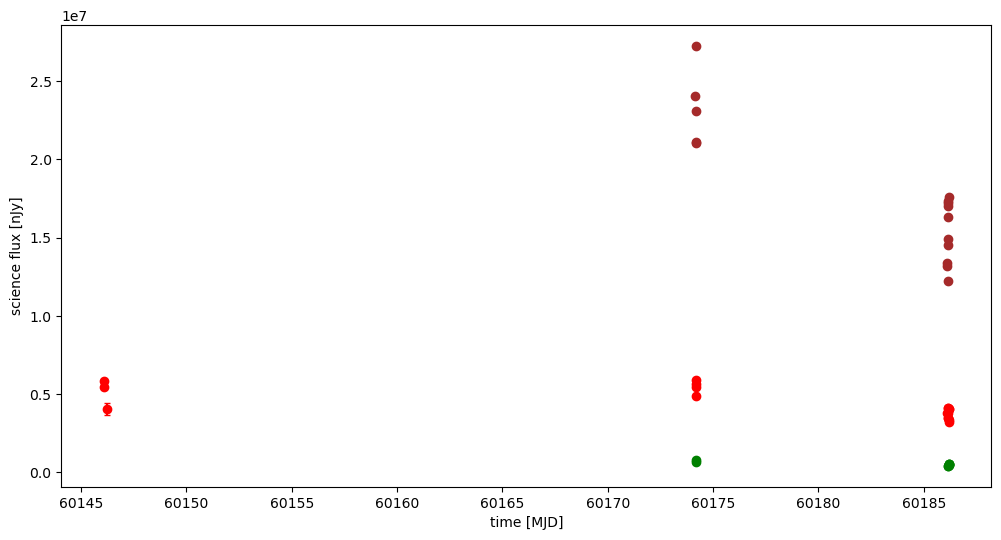

In [100]:
plt.figure(figsize=(12,6))
plt_color_band = ['green', 'red', 'brown']
for i,band in enumerate(['g', 'r', 'i']):
    sources_cortado_select_sband = sources_cortado_select[sources_cortado_select['band'] == band]

    plt.errorbar(sources_cortado_select_sband['midpointMjdTai'], sources_cortado_select_sband['scienceFlux'], yerr=sources_cortado_select_sband['scienceFluxErr'],
                 marker='o', capsize=2, ls='', color = plt_color_band[i])

    
plt.xlabel('time [MJD]')
plt.ylabel('science flux [nJy]')


Text(0, 0.5, 'science flux [nJy]')

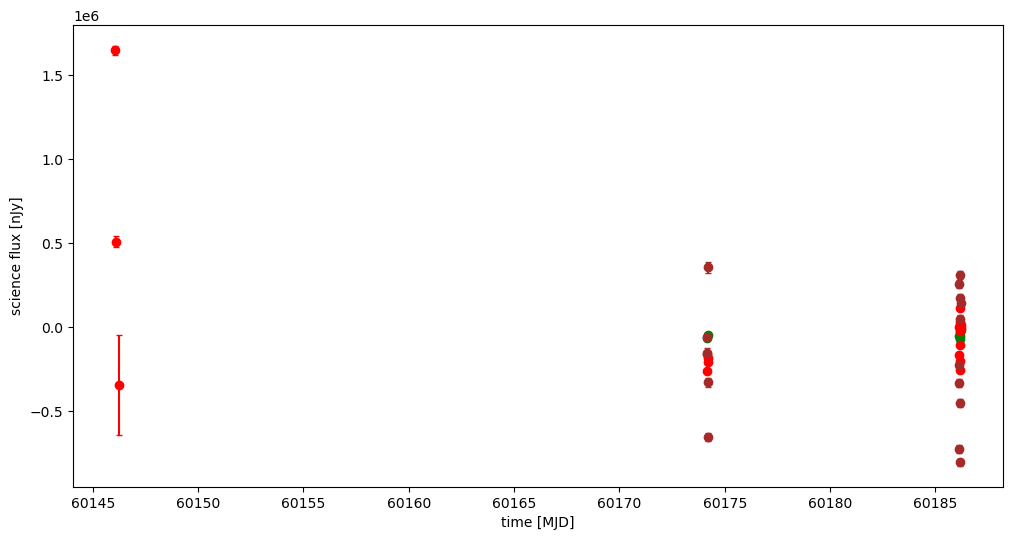

In [101]:
plt.figure(figsize=(12,6))
plt_color_band = ['green', 'red', 'brown']
for i,band in enumerate(['g', 'r', 'i']):
    sources_cortado_select_sband = sources_cortado_select[sources_cortado_select['band'] == band]

    plt.errorbar(sources_cortado_select_sband['midpointMjdTai'],sources_cortado_select_sband['psfFlux'],yerr=sources_cortado_select_sband['psfFluxErr'],
                 marker='o', capsize=2, ls='', color = plt_color_band[i])

plt.xlabel('time [MJD]')
plt.ylabel('science flux [nJy]')



Text(0, 0.5, 'science brightness [mag]')

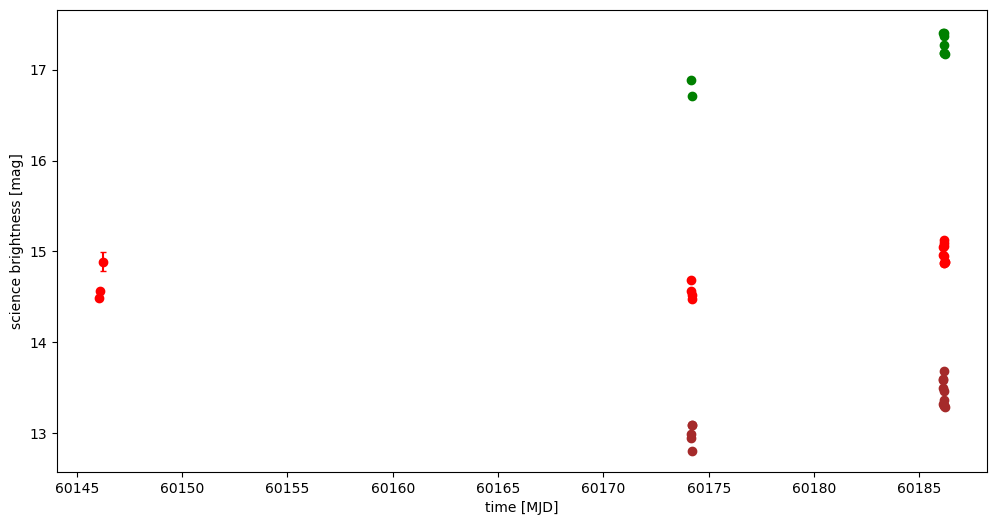

In [102]:
plt.figure(figsize=(12,6))
plt_color_band = ['green', 'red', 'brown']
for i,band in enumerate(['g', 'r', 'i']):
    sources_cortado_select_sband = sources_cortado_select[sources_cortado_select['band'] == band]

    plt.errorbar(sources_cortado_select_sband['midpointMjdTai'],sources_cortado_select_sband['mag'],yerr=sources_cortado_select_sband['magErr'],
                 marker='o', capsize=2, ls='', color = plt_color_band[i])
    
plt.xlabel('time [MJD]')
plt.ylabel('science brightness [mag]')

## Let us look at the single visit, single cutout

In [46]:
# let us try to get image from the visit 2023081700470

In [212]:
# The information from this querycan be also found here:
# https://confluence.lsstcorp.org/display/DM/Prompt+Processing+with+AuxTel+Imaging+Survey+Data+2023
! butler query-collections /sdf/group/rubin/repo/embargo "LATISS/prompt/*-2023-*/ApPipe/*"


                               Name                               Type
----------------------------------------------------------------- ----
LATISS/prompt/output-2023-05-24/ApPipe/prompt-proto-service-00026 RUN 
LATISS/prompt/output-2023-05-25/ApPipe/prompt-proto-service-00027 RUN 
LATISS/prompt/output-2023-07-20/ApPipe/prompt-proto-service-00007 RUN 
LATISS/prompt/output-2023-08-15/ApPipe/prompt-proto-service-00010 RUN 
LATISS/prompt/output-2023-08-16/ApPipe/prompt-proto-service-00011 RUN 
LATISS/prompt/output-2023-08-17/ApPipe/prompt-proto-service-00011 RUN 
LATISS/prompt/output-2023-08-29/ApPipe/prompt-proto-service-00013 RUN 


In [18]:
# Start with the time in modified julian date (MJD)
mjd = 60174.165443

# Convert to Julian Date
jd = mjd + 2400000.5

# Convert to astropy Time object
t = Time(jd, format='jd')

# Convert to datetime
utc = t.to_datetime()
utc

datetime.datetime(2023, 8, 18, 3, 58, 14, 275193)

In [19]:
! butler query-datasets /sdf/group/rubin/repo/embargo \
    --collections "LATISS/prompt/output-2023-08-17/ApPipe/prompt-proto-service-00011" \
    --where "instrument='LATISS' and detector=0 and band='g' and visit >= 2023081700470 and visit <= 2023081700470" \
    deepDiff_differenceExp


         type                                         run                                                 id                  band instrument detector physical_filter      visit    
---------------------- ----------------------------------------------------------------- ------------------------------------ ---- ---------- -------- ---------------- -------------
deepDiff_differenceExp LATISS/prompt/output-2023-08-17/ApPipe/prompt-proto-service-00011 c8def79d-ab38-47c4-a5d7-dd65cfc0a797    g     LATISS        0 SDSSg_65mm~empty 2023081700470



In [136]:
! butler query-datasets /sdf/group/rubin/repo/embargo \
    --collections "LATISS/prompt/output-2023-08-17/ApPipe/prompt-proto-service-00011" \
    --where "instrument='LATISS' and detector=0 and band='i' and visit >= 2023081700516 and visit <= 2023081700516" \
    deepDiff_differenceExp


         type                                         run                                                 id                  band instrument detector physical_filter      visit    
---------------------- ----------------------------------------------------------------- ------------------------------------ ---- ---------- -------- ---------------- -------------
deepDiff_differenceExp LATISS/prompt/output-2023-08-17/ApPipe/prompt-proto-service-00011 4025a068-2740-45ae-9e29-11d4b29fbafe    i     LATISS        0 SDSSi_65mm~empty 2023081700516



In [106]:
# with this infromation we can go into butler and get images
ap_collection = "LATISS/prompt/output-2023-08-17/ApPipe/prompt-proto-service-00011"
data_id = {"instrument": "LATISS", "detector": 0, "band": "i", "visit": 2023081700516}

calexp = butler.get("calexp", dataId=data_id, collections=ap_collection)
diff = butler.get("deepDiff_differenceExp", dataId=data_id, collections=ap_collection)
template = butler.get("deepDiff_templateExp", dataId=data_id, collections=ap_collection)
matched_template = butler.get("deepDiff_matchedExp", dataId=data_id, collections=ap_collection)

# Includes detections and sky sources. Direct output from detect+measure after image subtraction.
diaSrc = butler.get("deepDiff_diaSrc", dataId=data_id, collections=ap_collection)
# The SDM/DPDD (Science Data Model/Data Products Definition Document) version of the diaSrc Table. No sky sources.  Flags are packed into uint64.
diaSrcTable = butler.get("deepDiff_diaSrcTable", dataId=data_id, collections=ap_collection)

calexp

In [116]:
diaSrcTable.loc[111]['x']

1675.8905029296875

In [119]:
diaSrc[111].getX()

1675.8905029296875

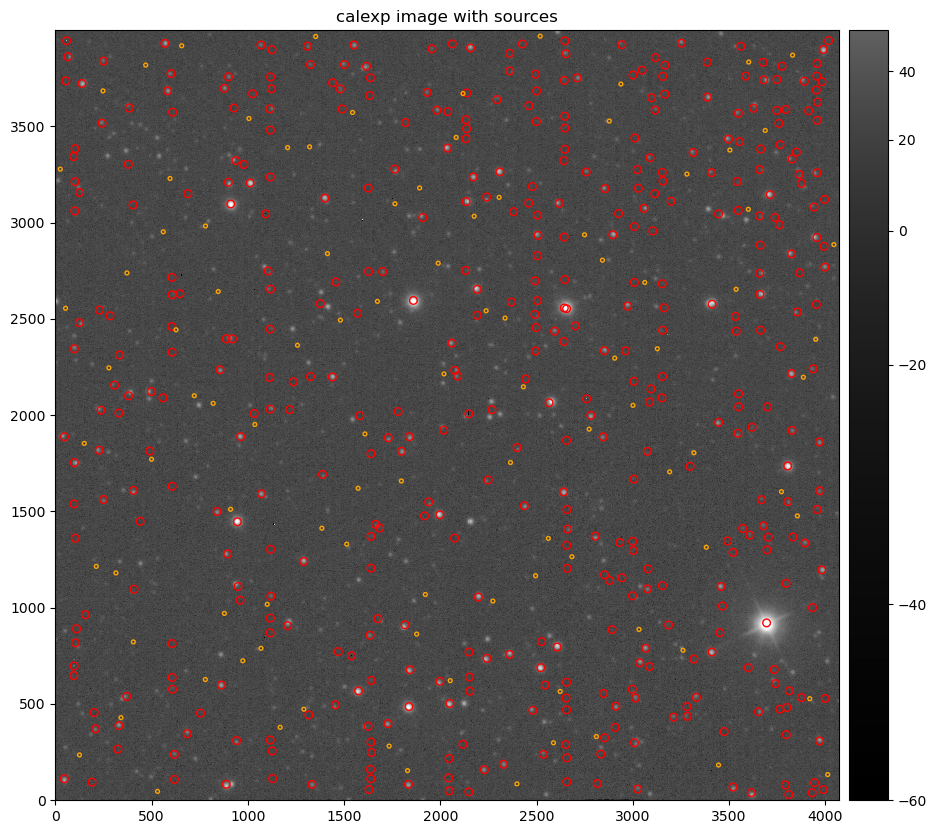

In [135]:
fig = plt.figure(figsize=(16, 10))
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(calexp.image)
with display.Buffering():
    for s in diaSrc:
        if s['sky_source']:
            display.dot("o", s.getX(), s.getY(), size=10, ctype="orange")
        else:
            display.dot("o", s.getX(), s.getY(), size=20, ctype="red")
        
plt.title('calexp image with sources')
plt.show()

In [137]:
def show_cutout_triplet(template, science, diff, x, y, size=30, figsize=(16, 8)):
    """
    Create and show a cutout of an template, science and difference image
    given a position
    """
    xy = geom.PointI(x, y)
    cutoutSize = geom.ExtentI(size, size)
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    
    assert template.getDimensions() == science.getDimensions() == diff.getDimensions()
    
    # clipping to the dimension of the image; prevents clipping outside of the image 
    bbox = bbox.clippedTo(template.getBBox())
    print(x, y, bbox)
    template_cutout = template.getCutout(bbox)
    science_cutout = science.getCutout(bbox)
    diff_cutout = diff.getCutout(bbox)

    # Use diff sigma for calexp, diff ranges.
    sigma = np.sqrt(np.median(diff.variance.array))

    fit, axes = plt.subplots(1, 3, figsize=figsize)
    plt.sca(axes[0])
    
    stretch =  AsinhStretch() 
    norm = ImageNormalize(stretch=stretch, vmin=0, vmax=np.quantile(template_cutout.image.array,0.99))
    plt.imshow(template_cutout.image.array, cmap="gray", norm=norm, origin='lower')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title("Template")
    plt.sca(axes[1])
    plt.imshow(science_cutout.image.array, cmap="gray", norm=norm, origin='lower')
    plt.title("Science")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.sca(axes[2])
    plt.imshow(diff_cutout.image.array, cmap="gray", vmin=-3*sigma, vmax=+3*sigma, origin='lower')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title("Diff")

In [138]:
sources_cortado_select.loc[28543]

diaSourceId       175077989564809969
diaObjectId       174092443820491173
ra                        270.245983
dec                       -24.987226
x                         1997.93201
y                        1482.624891
midpointMjdTai          60174.190808
psfFlux                356695.283797
psfFluxErr              30535.125954
scienceFlux          27240764.496468
scienceFluxErr          41427.290343
snr                        35.823074
band                               i
flags                        8388608
visit                  2023081700516
mag                        12.811952
magErr                      0.001651
Name: 28543, dtype: object

1997.932009591044 1482.6248910656154 (minimum=(1932, 1417), maximum=(2061, 1546))


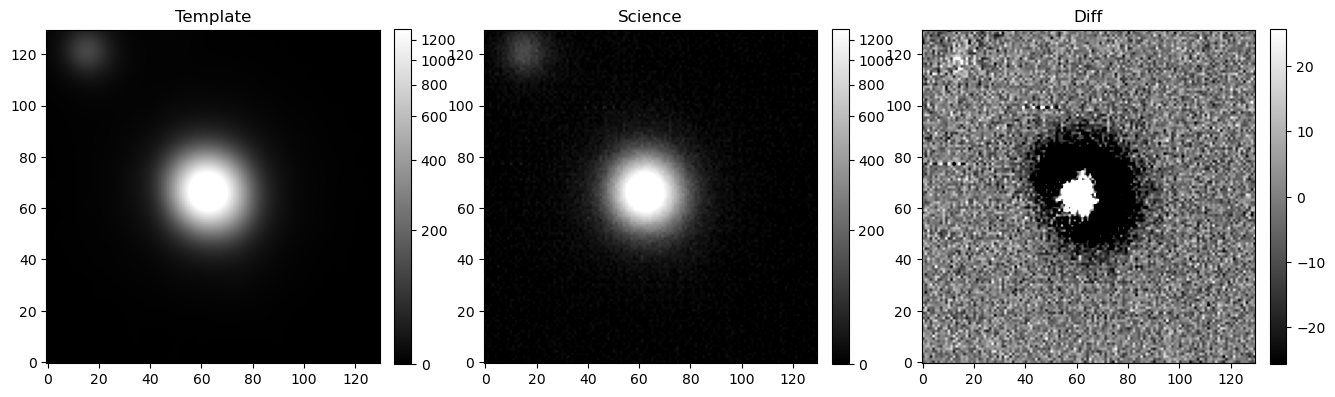

In [139]:
stamp_size = 30 # pixels.  Size of baseline alert stamp
stamp_size = 130 # pixels.  Bigger stamp to see more detail
x = sources_cortado_select.loc[28543]['x']
y = sources_cortado_select.loc[28543]['y']

show_cutout_triplet(matched_template, calexp, diff, x, y, size=stamp_size)

# Where are known variables

In [25]:
# I am having trouble finding true variables
# Let us try to find some real variables, and see how they look
# First, lets us find ra and dec of the fields that are covered by auxtel

Text(0, 0.5, 'dec')

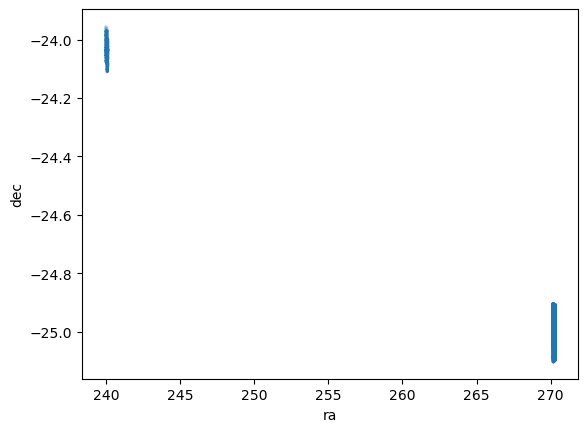

In [144]:
plt.scatter(sources_cortado['ra'],sources_cortado['dec'], s=0.001)
plt.xlabel('ra')
plt.ylabel('dec')

In [147]:
# There are two fields
# let us call it left and right field
left_field = sources_cortado[sources_cortado['ra']<245]
right_field = sources_cortado[sources_cortado['ra']>245]

Text(0, 0.5, 'dec')

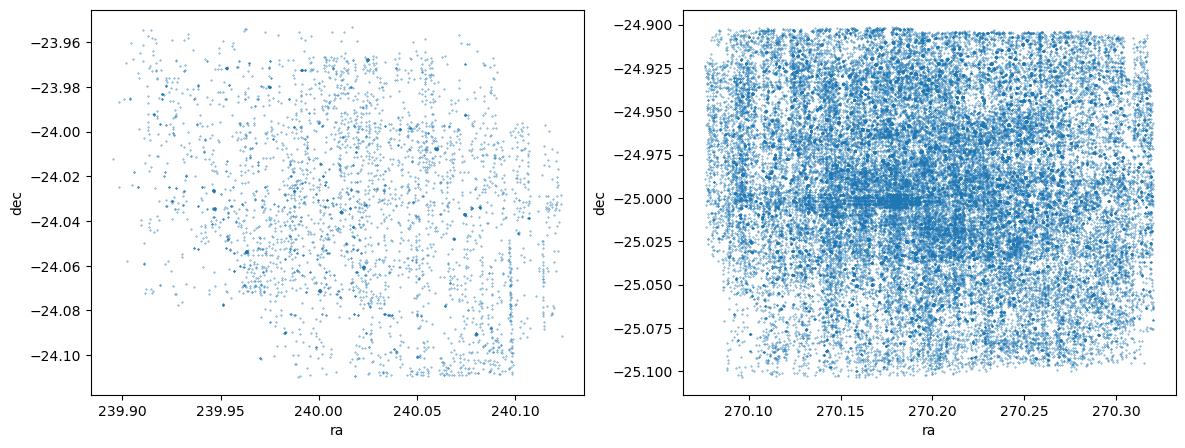

In [146]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.scatter(left_field['ra'], left_field['dec'], s=0.1)
plt.xlabel('ra')
plt.ylabel('dec')
plt.subplot(122)
plt.scatter(right_field['ra'], right_field['dec'], s=0.1)
plt.xlabel('ra')
plt.ylabel('dec')

In [29]:
# Select the edges of each field
lmin = list(map(np.min, [left_field['ra'],left_field['dec']]))
lmax = list(map(np.max, [left_field['ra'],left_field['dec']]))

rmin = list(map(np.min, [right_field['ra'],right_field['dec']]))
rmax = list(map(np.max, [right_field['ra'],right_field['dec']]))

In [149]:
size_of_l_field = (lmax[0] - lmin [0]) * (lmax[1] - lmin [1])
size_of_r_field = (rmax[0] - rmin [0]) * (rmax[1] - rmin [1])
# amount of sky covered by auxtel in these fields, in sq deg
print(f'amount of sky covered by auxtel in these fields, in sq deg: {size_of_l_field + size_of_r_field}')

amount of sky covered by auxtel in these fields, in sq deg: 0.08507624514290268


### DEPRECATED - First attempt (ZTF) - Not south enough 

In [31]:
# wget https://cdsarc.cds.unistra.fr/viz-bin/nph-Cat/fits?J/ApJS/249/18/table2.dat.gz
# catalog info here: https://cdsarc.cds.unistra.fr/viz-bin/cat/J/ApJS/249/18#/browse

In [94]:
from astropy.io import fits

In [112]:
var_cat = fits.open('/home/n/ncaplar/DATA/Chen_2020/fits?J%2FApJS%2F249%2F18%2Ftable2.dat.gz')[1].data
var_cat3 = fits.open('/home/n/ncaplar/DATA/Chen_2020/fits?J%2FApJS%2F249%2F18%2Ftable3.dat.gz')[1].data

In [107]:
# empty
var_cat[(var_cat['Radeg']>lmin[0]) & (var_cat['Radeg']<lmax[0]) &  (var_cat['DEdeg']>lmin[1]) & (var_cat['DEdeg']<lmax[1]) ]

FITS_rec([],
         dtype=(numpy.record, {'names': ['ID', 'Seq', 'RAdeg', 'DEdeg', 'Per', 'R21', 'phi21', 'T0', 'gmag', 'rmag', 'Per-g', 'Per-r', 'Ng', 'Nr', 'R21-g', 'R21-r', 'phi21-g', 'phi21-r', 'R2-g', 'R2-r', 'gAmp', 'rAmp', 'log(FAP-g)', 'log(FAP-r)', 'Type', 'Dmin-g', 'Dmin-r'], 'formats': ['S22', 'S6', 'S9', 'S9', 'S11', 'S6', 'S5', 'S13', 'S6', 'S6', 'S13', 'S13', 'S4', 'S4', 'S6', 'S6', 'S5', 'S5', 'S6', 'S6', 'S5', 'S5', 'S8', 'S8', 'S5', 'S5', 'S5'], 'offsets': [0, 23, 30, 40, 50, 62, 69, 75, 89, 96, 103, 117, 131, 136, 141, 148, 155, 161, 167, 174, 181, 187, 193, 202, 211, 217, 223], 'itemsize': 228}))

In [109]:
# empty
var_cat[(var_cat['Radeg']>rmin[0]) & (var_cat['Radeg']<rmax[0]) &  (var_cat['DEdeg']>rmin[1]) & (var_cat['DEdeg']<rmax[1]) ]

FITS_rec([],
         dtype=(numpy.record, {'names': ['ID', 'Seq', 'RAdeg', 'DEdeg', 'Per', 'R21', 'phi21', 'T0', 'gmag', 'rmag', 'Per-g', 'Per-r', 'Ng', 'Nr', 'R21-g', 'R21-r', 'phi21-g', 'phi21-r', 'R2-g', 'R2-r', 'gAmp', 'rAmp', 'log(FAP-g)', 'log(FAP-r)', 'Type', 'Dmin-g', 'Dmin-r'], 'formats': ['S22', 'S6', 'S9', 'S9', 'S11', 'S6', 'S5', 'S13', 'S6', 'S6', 'S13', 'S13', 'S4', 'S4', 'S6', 'S6', 'S5', 'S5', 'S6', 'S6', 'S5', 'S5', 'S8', 'S8', 'S5', 'S5', 'S5'], 'offsets': [0, 23, 30, 40, 50, 62, 69, 75, 89, 96, 103, 117, 131, 136, 141, 148, 155, 161, 167, 174, 181, 187, 193, 202, 211, 217, 223], 'itemsize': 228}))

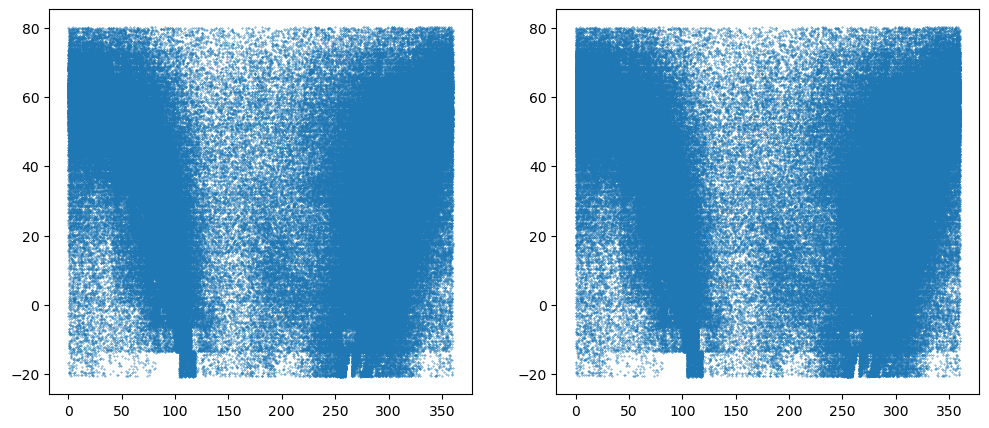

In [111]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(var_cat['Radeg'],var_cat['DEdeg'], s=0.1)
plt.subplot(122)
plt.scatter(var_cat['Radeg'],var_cat['DEdeg'], s=0.1)

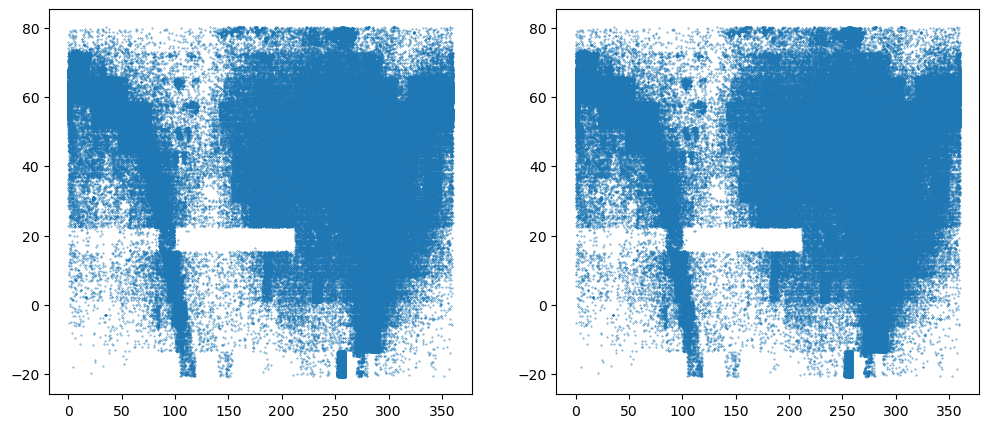

In [113]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(var_cat3['Radeg'],var_cat3['DEdeg'], s=0.1)
plt.subplot(122)
plt.scatter(var_cat3['Radeg'],var_cat3['DEdeg'], s=0.1)

### DEPRECATED - Second attempt (GAIA basic) - no variability info on usdf

In [125]:
from abc import ABC, abstractmethod
import glob

class RefcatInfo(ABC):
    PATH = ""
    NAME = ""

    def __init__(self, path=None, name=None):
        if path is None:
            self._path = self.PATH
        else:
            self._path = path

        if name is None:
            self._name = self.NAME
        else:
            self._name = name

    @property
    def path(self):
        return self._path

    @property
    def name(self):
        return self._name

    @abstractmethod
    def get_flux_field(self, band):
        """Get the flux field associated with a band.

        Parameters
        ----------
        band : `str`
            Name of band to get flux field.

        Returns
        -------
        flux_field : `str`
            Name of flux field appropriate for this catalog.
        """
        raise NotImplementedError()

    @abstractmethod
    def get_gmi_color_range(self):
        """Get the color range appropriate for the g-i color.

        Returns
        -------
        color_low, color_high : `float`
        """
        raise NotImplementedError()

    @abstractmethod
    def get_imz_color_range(self):
        """Get the color range appropriate for the i-z color.

        Returns
        -------
        color_low, color_high : `float`
        """
        raise NotImplementedError()

    def get_color_range(self, band):
        """Get the appropriate color range for a given band.

        Parameters
        ----------
        band : `str`
            Band to correct.

        Returns
        -------
        color_low, color_high : `float`
        """
        if band in ["g", "r", "i"]:
            color_range = self.get_gmi_color_range()
        elif band in ["z", "y"]:
            color_range = self.get_imz_color_range()

        return color_range

    def get_color_bands(self, band):
        """Get the appropriate bands to compute a color to correct
        a given band.

        Parameters
        ----------
        band : `str`
            Band to correct.

        Returns
        -------
        band_1, band_2 : `str`
        """
        if band in ["g", "r", "i"]:
            band_1 = "g"
            band_2 = "i"
        elif band in ["z", "y"]:
            band_1 = "i"
            band_2 = "z"
        else:
            raise NotImplementedError("Unsupported band: ", band)

        return band_1, band_2

    def get_mag_colors(self, catalog, band):
        """Get magnitude colors appropriate for correcting a given band.

        Parameters
        ----------
        catalog : `lsst.afw.table.SimpleCatalog`
            Input catalog.
        band : `str`
            Name of band for doing selection.

        Returns
        -------
        colors : `np.ndarray`
            Array of colors used for color terms for given band.
        """
        band_1, band_2 = self.get_color_bands(band)

        flux_color_field_1 = self.get_flux_field(band_1)
        flux_color_field_2 = self.get_flux_field(band_2)

        mag_color_1 = (np.array(catalog[flux_color_field_1])*units.nJy).to_value(units.ABmag)
        mag_color_2 = (np.array(catalog[flux_color_field_2])*units.nJy).to_value(units.ABmag)
        mag_color = mag_color_1 - mag_color_2

        return mag_color

    def select_stars(self, catalog, band):
        """Star selection appropriate for this type of refcat.

        Parameters
        ----------
        catalog : `lsst.afw.table.SimpleCatalog`
            Input catalog.
        band : `str`
            Name of band for doing selection.

        Returns
        -------
        selected : `np.ndarray`
            Boolean array of selected (True) or not (False).
        """
        mag_color = self.get_mag_colors(catalog, band)
        flux_field = self.get_flux_field(band)
        color_range = self.get_color_range(band)

        flux = np.array(catalog[flux_field])

        selected = (
            (mag_color > color_range[0])
            & (mag_color < color_range[1])
            & (np.isfinite(mag_color))
            & (np.isfinite(flux))
            & (flux < 1e10)
        )

        return selected

In [126]:
class GaiaDR3Info(RefcatInfo):
    PATH = "/sdf/data/rubin/shared/the_monster/GAIA_DR3/gaia_dr3"
    NAME = "GaiaDR3"

    def get_flux_field(self, band):
        return f"phot_{band.lower()}_mean_flux"

    def get_gmi_color_range(self):
        return (0.5, 3.0)

    def get_imz_color_range(self):
        return (0.0, 0.7)

In [127]:
#from lsst.the.monster import GaiaDR3Info, MatchAndTransform
#import glob


GaiaDR3CatInfoClass = GaiaDR3Info
gaia_info = GaiaDR3CatInfoClass()

# Make a list of all the Gaia shards:
fits_list = glob.glob(gaia_info.path+'/*.fits')

In [145]:
gaia_shard = fits.open(fits_list[100])

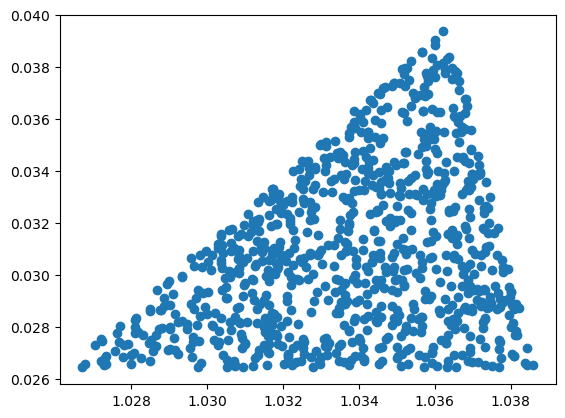

In [146]:
plt.scatter(gaia_shard[1].data['coord_ra'],gaia_shard[1].data['coord_dec'])

### Third attempt - GAIA (variability query)

In [141]:
# remind us, what are the limits of the fields
rmin

[270.0761449008231, -25.103422035979555]

In [140]:
rmax

[270.32041065889075, -24.901552217953647]

In [ ]:
# we run 4 queries; one basic for each field, and one with variability added

# L_field with variability
"""
SELECT dr3.source_id, dr3.ra, dr3.dec, dr3_sum.median_mag_g_fov, dr3_sum.std_dev_mag_g_fov
FROM gaiadr3.gaia_source AS dr3
JOIN gaiadr3.vari_summary AS dr3_sum ON 
dr3.source_id = dr3_sum.source_id
WHERE
dr3.ra BETWEEN 239.8952907175187 AND 240.12366266993158 AND
dr3.dec BETWEEN -24.109857437092213 AND -23.953242928900917
"""

In [142]:
# R_field with variability
"""
SELECT dr3.source_id, dr3.ra, dr3.dec, dr3_sum.median_mag_g_fov, dr3_sum.std_dev_mag_g_fov
FROM gaiadr3.gaia_source AS dr3
JOIN gaiadr3.vari_summary AS dr3_sum ON 
dr3.source_id = dr3_sum.source_id
WHERE
dr3.ra BETWEEN 270.0761449008231 AND 270.32041065889075 AND
dr3.dec BETWEEN -25.103422035979555 AND -24.901552217953647
"""

SyntaxError: invalid syntax (2557053762.py, line 1)

In [ ]:
# L_field (equivallent code for R_field)
"""
SELECT dr3.source_id, dr3.ra, dr3.dec
FROM gaiadr3.gaia_source AS dr3
WHERE
dr3.ra BETWEEN 270.0761449008231 AND 270.32041065889075 AND
dr3.dec BETWEEN -25.103422035979555 AND -24.901552217953647
"""

In [33]:
# we download data as fits and open
lfield_gaia = fits.open('/home/n/ncaplar/DATA/GAIA/l_field.fits.gz')[1].data
lfield_gaia_var = fits.open('/home/n/ncaplar/DATA/GAIA/l_field_var.fits.gz')[1].data
rfield_gaia = fits.open('/home/n/ncaplar/DATA/GAIA/r_field.fits.gz')[1].data
rfield_gaia_var = fits.open('/home/n/ncaplar/DATA/GAIA/r_field_var.fits.gz')[1].data

Text(0, 0.5, 'dec')

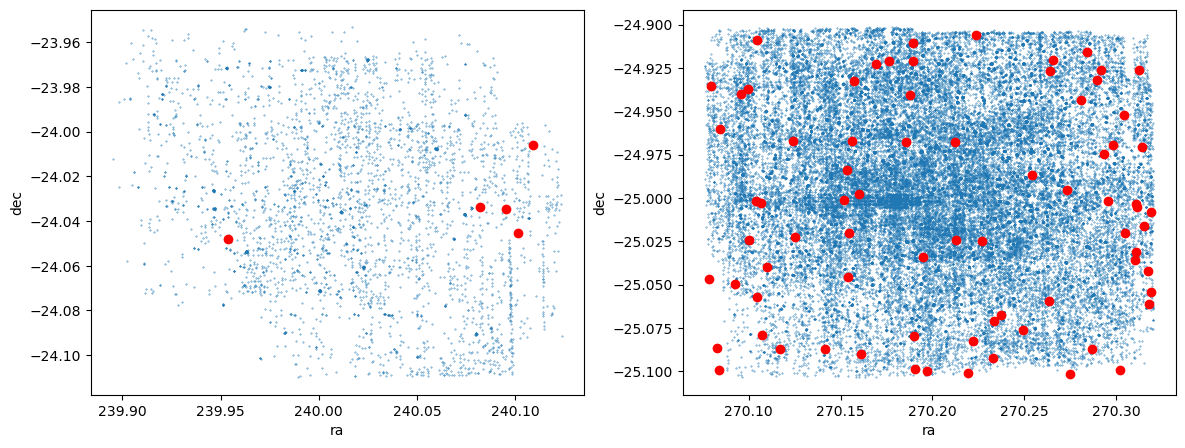

In [150]:
# overplot diaSoruces via gaia variable objects
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.scatter(left_field['ra'],left_field['dec'], s=0.1)
plt.scatter(lfield_gaia_var['ra'],lfield_gaia_var['dec'], color = 'red')
plt.xlabel('ra')
plt.ylabel('dec')
plt.subplot(122)
plt.scatter(right_field['ra'],right_field['dec'], s=0.1)
plt.scatter(rfield_gaia_var['ra'],rfield_gaia_var['dec'], color = 'red')
plt.xlabel('ra')
plt.ylabel('dec')

In [151]:
# a = Angle(diaSrc['coord_ra'], u.radian)

In [152]:
# move to degrees
diaSrc_ra = u.radian.to(u.deg, diaSrc['coord_ra'])
diaSrc_deg = u.radian.to(u.deg, diaSrc['coord_dec'])

Text(0, 0.5, 'dec')

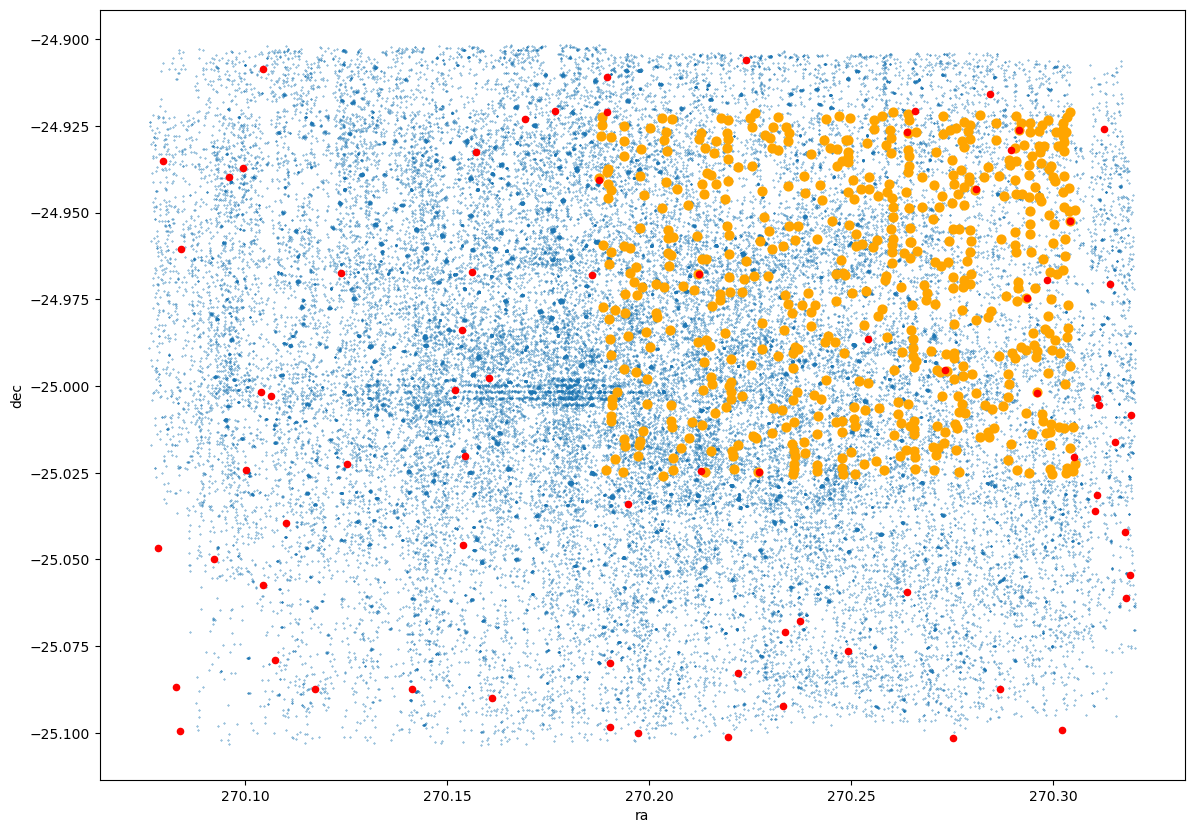

In [160]:
# That one exposure that we loaded was in the right field
# overplot in orange diaSources forom that one exposure
plt.figure(figsize=(14,10))
plt.scatter(right_field['ra'],right_field['dec'], s=0.1)
plt.scatter(diaSrc_ra, diaSrc_deg, color = 'orange', s=40)
plt.scatter(rfield_gaia_var['ra'],rfield_gaia_var['dec'], color = 'red', s=20)
plt.xlabel('ra')
plt.ylabel('dec')

In [38]:
# Crossmatch diaSources from that one exposure and variable gaia objects
# create catalogs in astropy friendly format
diaSrc_cat= SkyCoord(ra=diaSrc_ra*u.degree, dec=diaSrc_deg*u.degree)
rfield_cat = SkyCoord(ra=rfield_gaia_var['ra']*u.degree, dec=rfield_gaia_var['dec']*u.degree)

In [39]:
# find matches within 1 arcsec
idx, d2d, d3d = diaSrc_cat.match_to_catalog_sky(rfield_cat)
max_sep = 1.0 * u.arcsec
sep_constraint = d2d < max_sep
diaSrc_matches = diaSrc_cat[sep_constraint]
rfield_matches = rfield_cat[idx[sep_constraint]]

In [40]:
# this is our gaia catalog which was matched to diaSources
rfield_gaia_var[idx[sep_constraint]]

FITS_rec([(4064473241828512128, 270.22711131, -25.02474912, 15.942292 , 0.17915869),
          (4064474650577755904, 270.29596154, -25.00184824,  7.6566815, 0.13859004),
          (4064475097246697088, 270.29346201, -24.97460987, 17.480766 , 0.06234546),
          (4064475642680478720, 270.21228337, -24.96767536, 15.819856 , 0.02914872),
          (4064475337773147776, 270.30417861, -24.95234077, 15.673216 , 0.20097654),
          (4064476265477925760, 270.29167225, -24.92621012, 18.94339  , 0.27930155)],
         dtype=(numpy.record, [('source_id', '>i8'), ('ra', '>f8'), ('dec', '>f8'), ('median_mag_g_fov', '>f4'), ('std_dev_mag_g_fov', '>f4')]))

In [41]:
# this is our diaSrc catalog which was matched to variable Gaia
# supress output because it is huge
diaSrc_gaia_var = diaSrc[sep_constraint];

In [42]:
# check that indeed none of the selected sources are sky sources
# looks good
diaSrc_gaia_var['sky_source']

array([False, False, False, False, False, False])

In [164]:
diaSrc_gaia_var['id']

array([175077989564809821, 175077989564809930, 175077989564810006,
       175077989564810040, 175077989564810096, 175077989564810226])

In [198]:
# other way to get the same information
# select only the ones that have cleanflags 
diaSrc_gaia_var = np.intersect1d(sources_cortado['diaSourceId'],diaSrc[sep_constraint]['id'])

In [178]:
# this is because one of them was excluded when flagged
sources_all[sources_all['diaSourceId'] ==175077989564809930].index[0]

66925

In [202]:
sources_cortado_gaia = sources_cortado[sources_cortado['diaSourceId'].isin(diaSrc_gaia_var)]
 

In [211]:
sources_cortado_gaia

diaSourceId         diaObjectId          ra        dec  \
28439  175077989564809821  174092445967975210  270.226996 -25.024678   
28573  175077989564810006  174092459926618638  270.293380 -24.974592   
28601  175077989564810040  174092443820491098  270.212208 -24.967565   
28634  175077989564810096  174092505023776023  270.304153 -24.952355   
28721  175077989564810226  175077989564810226  270.291695 -24.926113   

                 x            y  midpointMjdTai        psfFlux    psfFluxErr  \
28439  1333.103027    82.075333    60174.190808  339481.822781  10961.042753   
28573  3619.840576  1937.489502    60174.190808   38961.119002   7665.525895   
28601   855.693176  2236.136230    60174.190808  119166.205450  11611.578571   
28634  3998.051025  2769.104736    60174.190808 -196207.026315  11852.614672   
28721  3586.025146  3761.428223    60174.190808  -34655.025629   6615.148801   

        scienceFlux  scienceFluxErr        snr band    flags          visit  
28439  1.856681e+06    14461.730478  30.915424    i        0  2023081700516  
28573  3.082244e+05    10186.822355   5.070557    i        0  2023081700516  
28601  2.580685e+06    15088.017689  10.140855    i        0  2023081700516  
28634  3.136666e+06    15694.914441  16.735538    i        0  2023081700516  
28721  8.739143e+04     8611.447169   5.283313    i  8388608  2023081700516

1333.10302734375 82.07533264160156 (minimum=(1268, 17), maximum=(1397, 146))
3619.840576171875 1937.489501953125 (minimum=(3554, 1872), maximum=(3683, 2001))
855.6931762695312 2236.13623046875 (minimum=(790, 2171), maximum=(919, 2300))
3998.051025390625 2769.104736328125 (minimum=(3933, 2704), maximum=(4062, 2833))
3586.025146484375 3761.42822265625 (minimum=(3521, 3696), maximum=(3650, 3825))


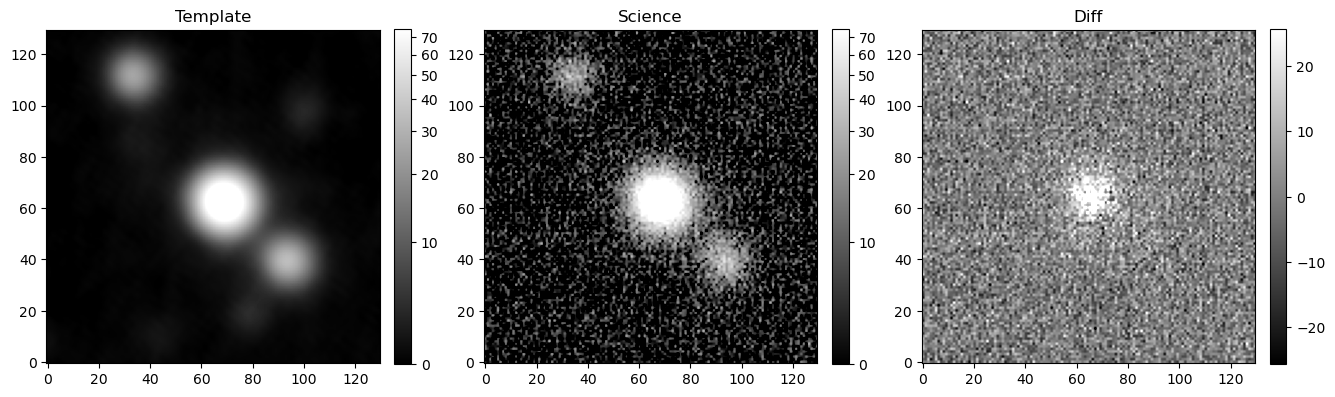

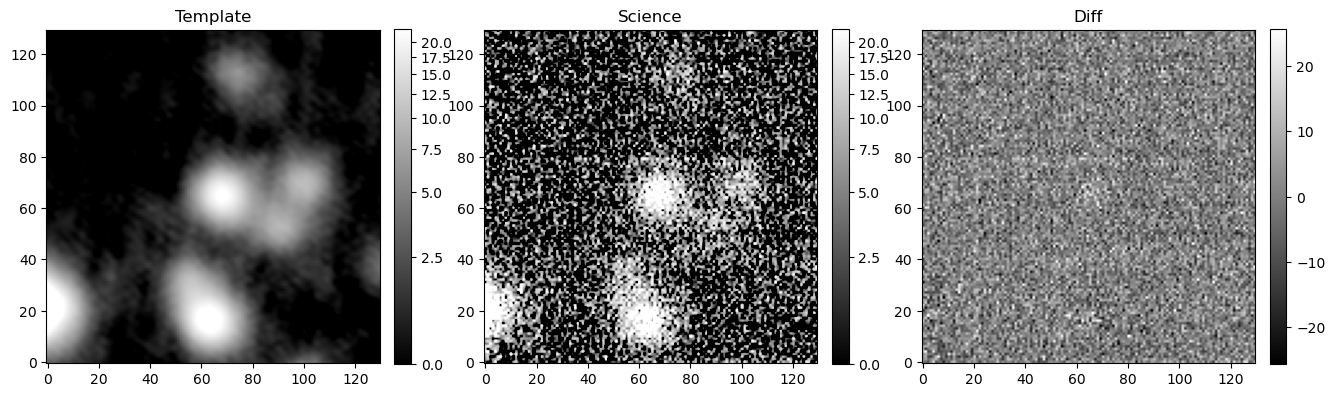

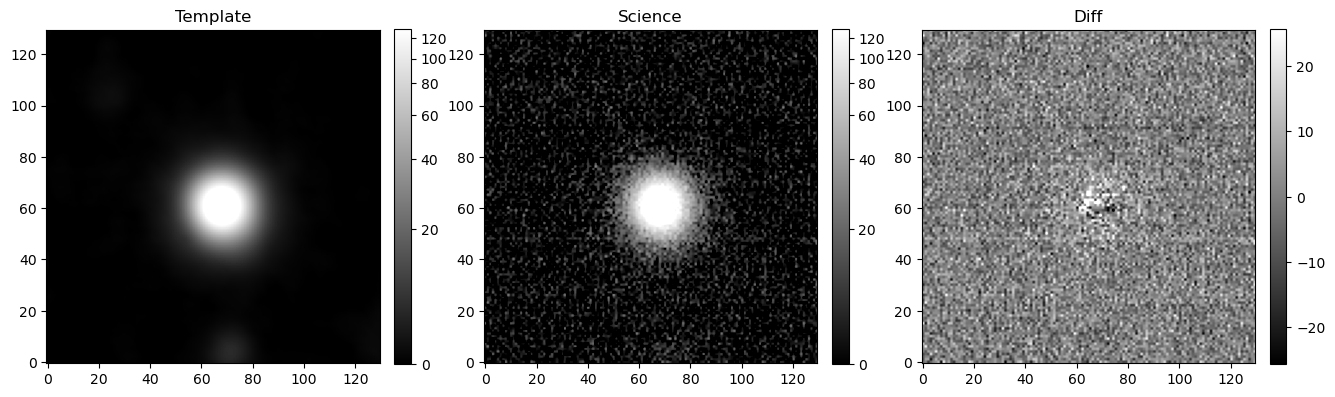

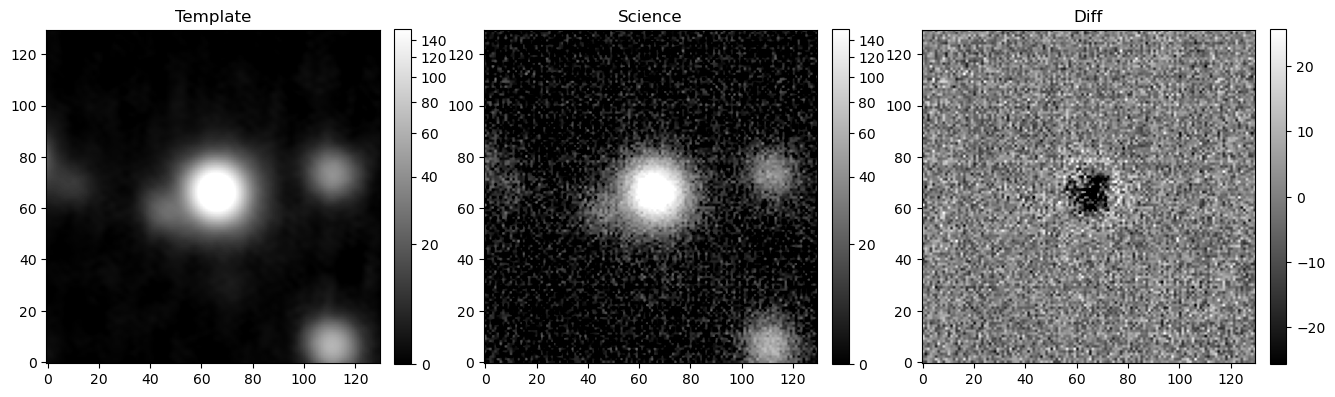

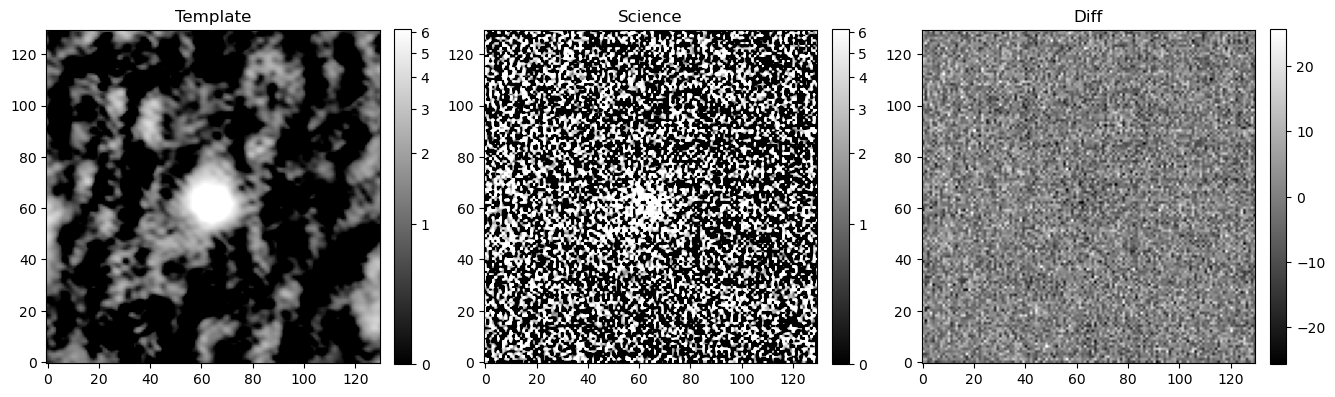

In [215]:
# plots of our 5 variables in this one random exposure
for index, row in sources_cortado_gaia.iterrows():
    x = row['x']
    y = row['y']
    
    show_cutout_triplet(matched_template, calexp, diff, x, y, size=stamp_size)

In [218]:
sources_cortado_gaia

diaSourceId         diaObjectId          ra        dec  \
28439  175077989564809821  174092445967975210  270.226996 -25.024678   
28573  175077989564810006  174092459926618638  270.293380 -24.974592   
28601  175077989564810040  174092443820491098  270.212208 -24.967565   
28634  175077989564810096  174092505023776023  270.304153 -24.952355   
28721  175077989564810226  175077989564810226  270.291695 -24.926113   

                 x            y  midpointMjdTai        psfFlux    psfFluxErr  \
28439  1333.103027    82.075333    60174.190808  339481.822781  10961.042753   
28573  3619.840576  1937.489502    60174.190808   38961.119002   7665.525895   
28601   855.693176  2236.136230    60174.190808  119166.205450  11611.578571   
28634  3998.051025  2769.104736    60174.190808 -196207.026315  11852.614672   
28721  3586.025146  3761.428223    60174.190808  -34655.025629   6615.148801   

        scienceFlux  scienceFluxErr        snr band    flags          visit  
28439  1.856681e+06    14461.730478  30.915424    i        0  2023081700516  
28573  3.082244e+05    10186.822355   5.070557    i        0  2023081700516  
28601  2.580685e+06    15088.017689  10.140855    i        0  2023081700516  
28634  3.136666e+06    15694.914441  16.735538    i        0  2023081700516  
28721  8.739143e+04     8611.447169   5.283313    i  8388608  2023081700516